In [5]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['SPARK_HOME'] = os.getenv('SPARK_HOME')
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = 'lab'
os.environ['PYSPARK_PYTHON'] = "python"

In [6]:
from pyspark.sql import SparkSession

In [7]:
spark = SparkSession.builder.master('local[*]').appName('Mediacal_cost_prediction').getOrCreate()

In [8]:
df = spark.read.csv('../data/medical.csv', header=True, inferSchema=True)
df.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [9]:
from pyspark.sql.functions import mean, max, min

numerical_cols = [col for col in df.columns if col in {'age', 'bmi', 'children', 'charges'}]

print("Average values for numerical columns")
df.select(*[mean(c) for c in numerical_cols]).show()
print("Maximum values for numerical columns")
df.select(*[max(c) for c in numerical_cols]).show()
print("Minimum values for numerical columns")
df.select(*[min(c) for c in numerical_cols]).show()

Average values for numerical columns
+-----------------+------------------+---------------+------------------+
|         avg(age)|          avg(bmi)|  avg(children)|      avg(charges)|
+-----------------+------------------+---------------+------------------+
|39.20702541106129|30.663396860986538|1.0949177877429|13270.422265141257|
+-----------------+------------------+---------------+------------------+

Maximum values for numerical columns
+--------+--------+-------------+------------+
|max(age)|max(bmi)|max(children)|max(charges)|
+--------+--------+-------------+------------+
|      64|   53.13|            5| 63770.42801|
+--------+--------+-------------+------------+

Minimum values for numerical columns
+--------+--------+-------------+------------+
|min(age)|min(bmi)|min(children)|min(charges)|
+--------+--------+-------------+------------+
|      18|   15.96|            0|   1121.8739|
+--------+--------+-------------+------------+



In [10]:
categorical_cols = [col for col in df.columns if col not in {'age', 'bmi', 'children', 'charges'}]

print("Unique values for each categorical column")
for col in categorical_cols:
    df.groupBy(col).count().show()

Unique values for each categorical column
+------+-----+
|   sex|count|
+------+-----+
|female|  662|
|  male|  676|
+------+-----+

+------+-----+
|smoker|count|
+------+-----+
|    no| 1064|
|   yes|  274|
+------+-----+

+---------+-----+
|   region|count|
+---------+-----+
|northwest|  325|
|southeast|  364|
|northeast|  324|
|southwest|  325|
+---------+-----+



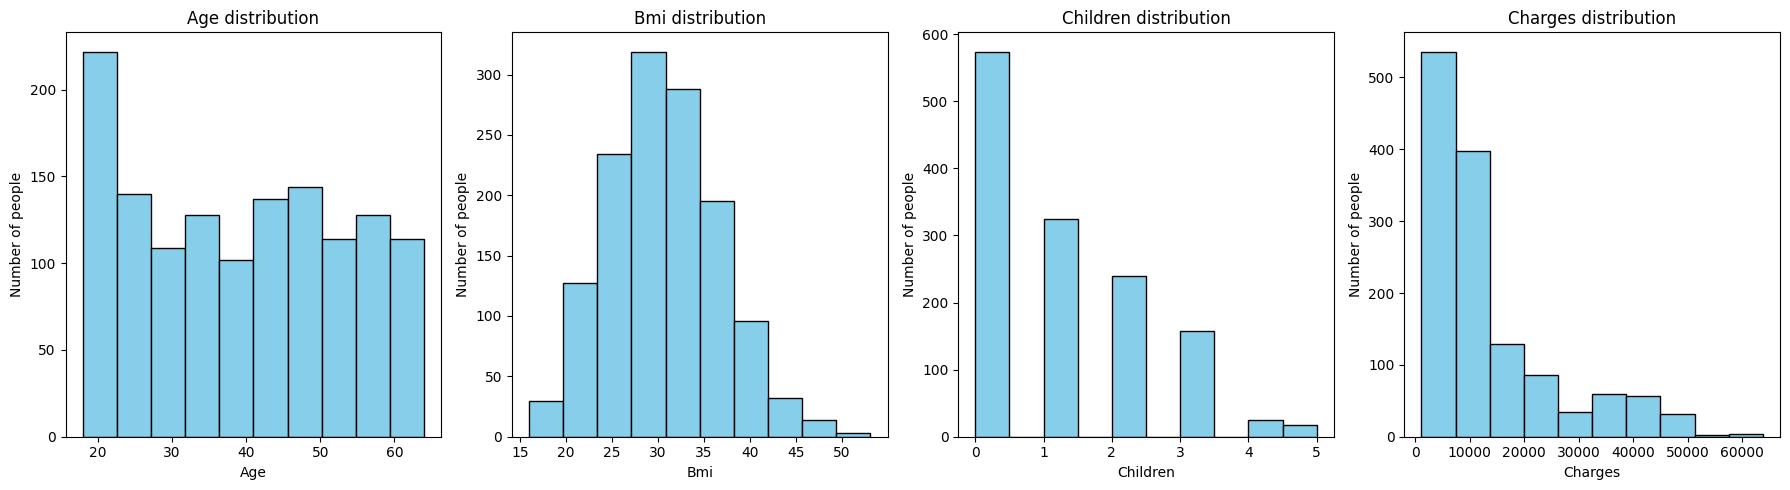

In [11]:
import matplotlib.pyplot as plt

numerical_cols = ['age', 'bmi', 'children', 'charges']
numerical_data = df.select(numerical_cols).toPandas()

fig, axes = plt.subplots(1, len(numerical_cols), figsize=(18, 5))

for i, col in enumerate(numerical_cols):
    axes[i].hist(numerical_data[col], bins=10, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{col.capitalize()} distribution')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Number of people')
    
plt.tight_layout()
plt.show()

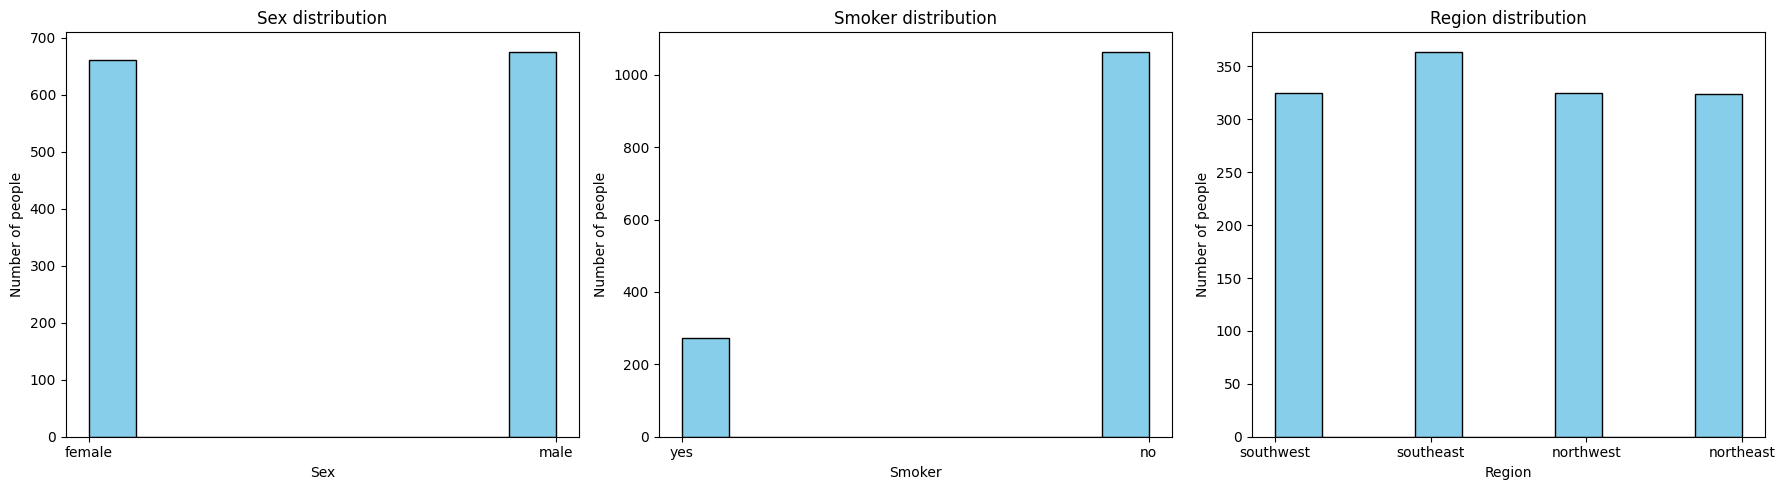

In [12]:
categorical_cols = ['sex', 'smoker', 'region']
categorical_data = df.select(categorical_cols).toPandas()

fig, axes = plt.subplots(1, len(categorical_cols), figsize=(18, 5))

for i, col in enumerate(categorical_cols):
    axes[i].hist(categorical_data[col], bins=10, color='skyblue', edgecolor='black')
    axes[i].set_title(f"{col.capitalize()} distribution")
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel("Number of people")

plt.tight_layout()
plt.show()

d:\ml\Medical_Cost_Prediction_with_PySpark\.venv\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


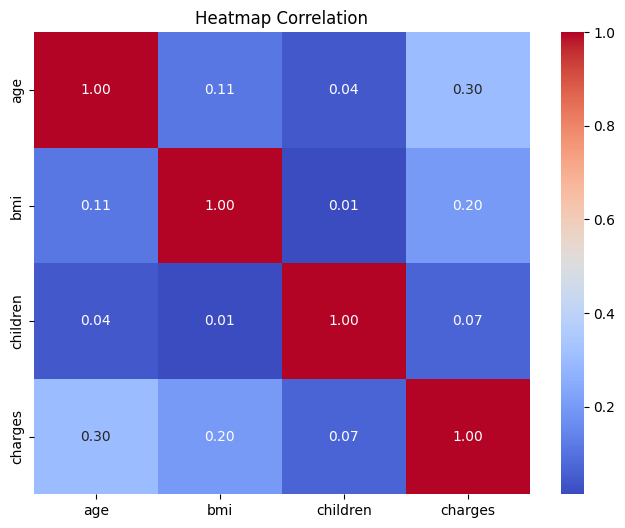

In [13]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import seaborn as sns

assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
vector_df = assembler.transform(df).select('features')

corelation_matrix = Correlation.corr(vector_df, 'features').head()[0].toArray()
corelation_df = pd.DataFrame(corelation_matrix, columns=numerical_cols, index=numerical_cols)

plt.figure(figsize=(8,6))
sns.heatmap(corelation_df, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Heatmap Correlation")
plt.show()

C:\Users\drasz\AppData\Local\Temp\ipykernel_15044\3399929402.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=charges_by_regions, x='region', y='avg(charges)', palette='pastel')


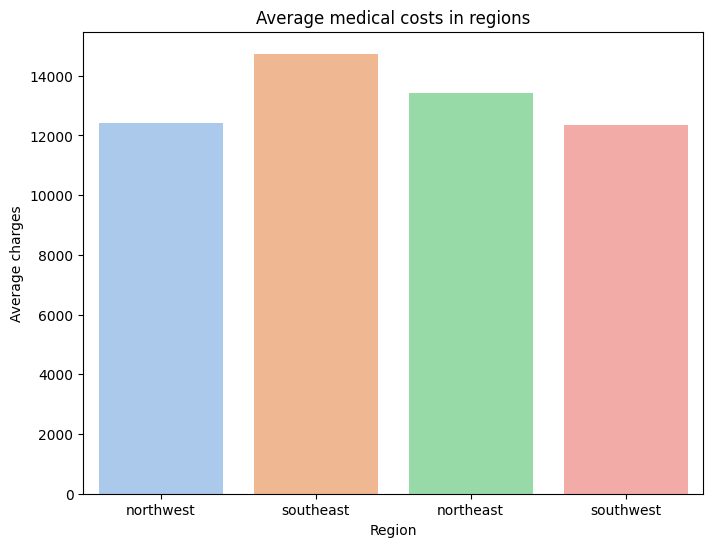

In [14]:
charges_by_regions = df.groupBy('region').agg({'charges': 'mean'}).toPandas()

plt.figure(figsize=(8,6))
sns.barplot(data=charges_by_regions, x='region', y='avg(charges)', palette='pastel')
plt.title("Average medical costs in regions")
plt.xlabel("Region")
plt.ylabel("Average charges")
plt.show()

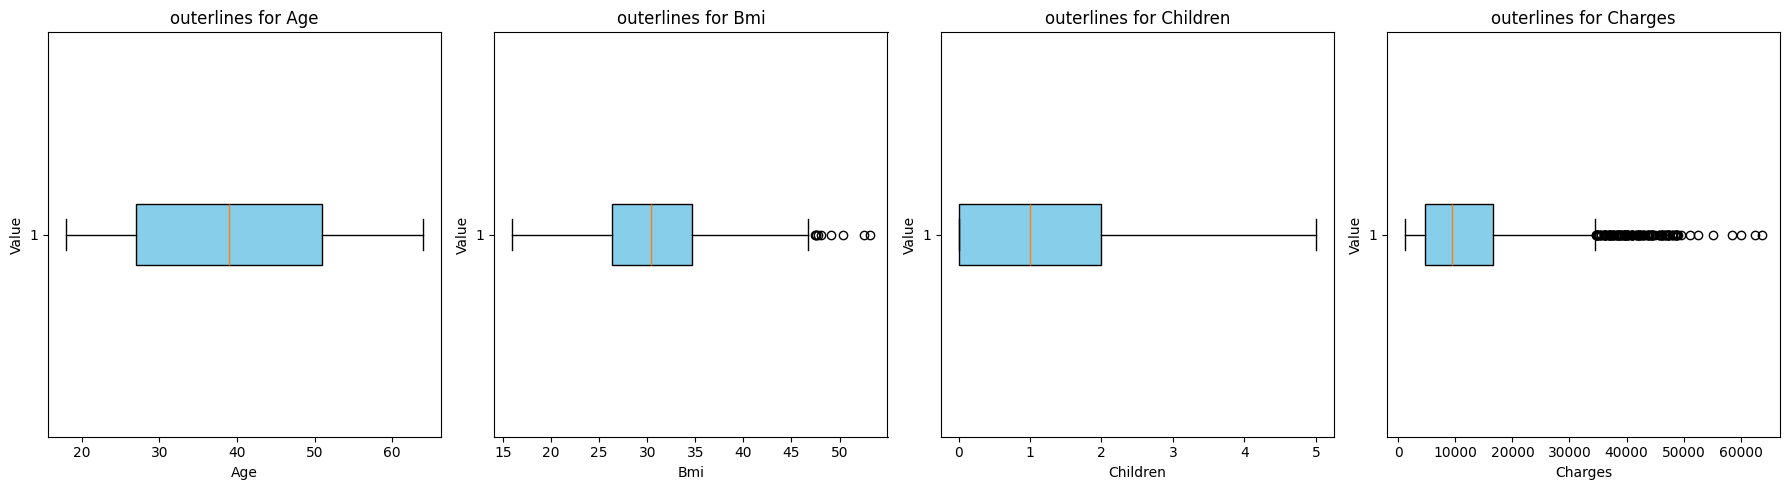

In [15]:
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(18, 5))

for i, col in enumerate(numerical_cols):
    axes[i].boxplot(numerical_data[col], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    axes[i].set_title(f'outerlines for {col.capitalize()}')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel("Value")
    
plt.tight_layout()
plt.show()

In [16]:
spark.stop()